In [1]:
# Load the required packages
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Prep Reuters
max_words = 10000  # Top 10k words
max_len = 200  # Max length
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=max_words)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
num_classes = 46  # 46 topics
y_train = to_categorical(y_train, num_classes)  # One-hot encode
y_test = to_categorical(y_test, num_classes)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Vanilla LSTM
def build_vanilla_lstm():
    model = Sequential()
    model.add(Embedding(max_words, 32, input_length=max_len))
    model.add(LSTM(32))  # 32 units
    model.add(Dense(num_classes, activation='softmax'))  # 46 classes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1)
    return history, model

In [4]:
# LSTM with Attention
def build_attention_lstm():
    inputs = Input(shape=(max_len,))
    embedding = Embedding(max_words, 32, input_length=max_len)(inputs)
    lstm_out = LSTM(32, return_sequences=True)(embedding)  # All time steps
    attention = Attention()([lstm_out, lstm_out])  # Self-attention
    flat = Flatten()(attention)
    output = Dense(num_classes, activation='softmax')(flat)
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1)
    return history, model

In [5]:
# Train both
histories, models = zip(*[build_vanilla_lstm(), build_attention_lstm()])

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - accuracy: 0.3269 - loss: 3.3487 - val_accuracy: 0.3620 - val_loss: 2.4302
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.3832 - loss: 2.3546 - val_accuracy: 0.5058 - val_loss: 2.0581
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 241ms/step - accuracy: 0.4870 - loss: 2.0866 - val_accuracy: 0.5294 - val_loss: 1.9261
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 0.5372 - loss: 1.8658 - val_accuracy: 0.5686 - val_loss: 1.7470
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.5759 - loss: 1.6701 - val_accuracy: 0.5801 - val_loss: 1.7710
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 287ms/step - accuracy: 0.3259 - loss: 2.6287 - val_accuracy: 0.5183 - val_loss: 1.8814
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.5636 - loss: 1.7161 - val_accuracy: 0.6487 - val_loss: 1.4700
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - accuracy: 0.6933 - loss: 1.2335 - val_accuracy: 0.6932 - val_

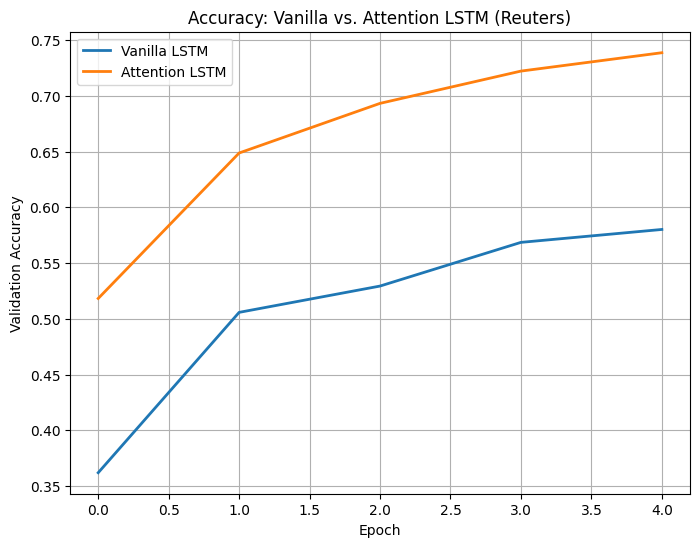

In [6]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(histories[0].history['val_accuracy'], label='Vanilla LSTM', linewidth=2)
plt.plot(histories[1].history['val_accuracy'], label='Attention LSTM', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy: Vanilla vs. Attention LSTM (Reuters)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy.png', dpi=150, bbox_inches='tight')

In [7]:
# Attention weights (sample)
def plot_attention_weights(model, filename):
    sample = X_train[:1]  # First snippet
    lstm_out = model.layers[2](model.layers[1](sample))  # LSTM output
    attn_weights = model.layers[3]([lstm_out, lstm_out]).numpy()[0, :, 0]  # Weights
    plt.figure(figsize=(10, 2))
    plt.bar(range(max_len), attn_weights, color='purple')
    plt.xlabel('Word Position')
    plt.ylabel('Attention Weight')
    plt.title('Attention Weights (Sample News Snippet)')
    plt.savefig(filename, dpi=150, bbox_inches='tight')

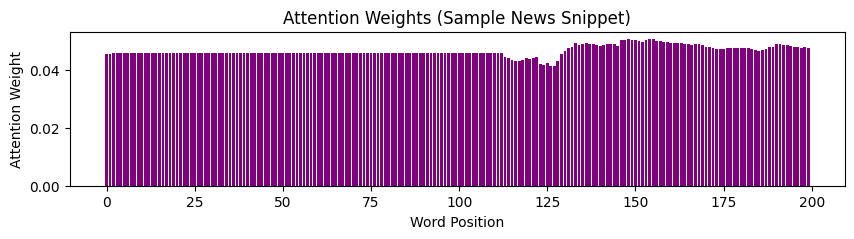

In [8]:
plot_attention_weights(models[1], 'attention_weights.png')

In [9]:
# Print accuracies
print(f"Vanilla LSTM - Final Val Accuracy: {histories[0].history['val_accuracy'][-1]:.4f}")
print(f"Attention LSTM - Final Val Accuracy: {histories[1].history['val_accuracy'][-1]:.4f}")

Vanilla LSTM - Final Val Accuracy: 0.5801
Attention LSTM - Final Val Accuracy: 0.7386
